# [Analyzing a Bunch of Whiskys With Python](https://tselai.com/greek-wines-analysis.html)

One of my most enjoyable guilty pleasures has always been [web scraping](https://en.wikipedia.org/wiki/Web_scraping).
Especially during the past year I have scraped countless websites, both for fun and profit.
From niche and mainstream e-shops to news outlets and literary blogs, it is amazing how much interesting and clean data one can get by using simple tools like `BeautifulSoup`- I won't even mention what a joy Chrome's Headless mode has been.

In this post I'll play with the data I scraped from a [Greek wine e-shop](http://www.houseofwine.gr/). In lieu of apology for sending a few more requests to their server I urge everyone browse through their catalog and maybe even buy a few bottles.

The scraper itself is fairly simple and can be found on my [GitHub page](https://github.com/Florents-Tselai/greek-wines-analysis). Here I'll focus on doing some quick exploratory analysis on the data I got (1125 unique labels) by using standard python packages.

The scraper itself exposes a fairly simple API. You request data for a given whisky page and it returns a nice `dict` with the data, like this:

In [32]:
from whisky_de import get

In [33]:
url='https://www.whisky.de/shop/Schottland/Single-Malt/Islay/Lagavulin-8-Jahre.html'

print(get(url))

https://www.whisky.de/shop/Schottland/Single-Malt/Islay/Lagavulin-8-Jahre.html
{'whisky_type': 'Single Malt Whisky', 'description': 'Die Brennerei Lagavulin besteht bereits seit 200 Jahren. Zu ihrem Jubiläum wurde dieser 8-jährige Single Malt abgefüllt. Das Alter von acht Jahren erinnert auch an einen weiteren, wichtigen Meilenstein in der Brennereigeschichte. Um 1880 verkostete der bekannte Whiskyjournalist Alfred Barnard bei seinem Besuch einen 8-jährigen Lagavulin.Limitierte Abfüllung.', 'taste_box_sweet': '46', 'url': 'https://www.whisky.de/shop/Schottland/Single-Malt/Islay/Lagavulin-8-Jahre.html', 'taste_box_sherry_port_barrel': '12', 'taste_box_qualitiy': '72', 'taste_box_gravy': '70', 'n_votes': '42', 'alcohol_%': 48.0, 'taste_box_fruits': '54', 'price': 4790, 'distillery': 'Lagavulin Distillery Port Ellen Isle of Islay PA42 7DZ/GB', 'taste_box_smoke_torf': '53', 'country': 'Scotland', 'taste_box_total': '71', 'img': 'https://www.whisky.de/shop/out/pictures/generated/product/1/6

We start by defining some `matplotlib` aesthetics.

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

plt.style.use('fivethirtyeight')

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Serif'
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.grid'] =False
plt.rcParams['figure.facecolor']='white'

We load a dump of the data produced by the `houseofwine_gr.dump` module. You can find the dataset in `.json, .csv and .xlsx` in the GitHub page as well.

In [35]:
import pandas as pd

df = pd.read_json('./data/whisky.json', encoding='utf-8')

Here's a view of the data we have.

In [36]:
df.head()

,alcohol_%,avg_rating_%,country,description,distillery,img,n_votes,name,price,taste_box_fruits,taste_box_gravy,taste_box_qualitiy,taste_box_sherry_port_barrel,taste_box_smoke_torf,taste_box_sweet,taste_box_total,url,whisky_type
0,43.0,5.0,Scotland,Der unabhängige Abfüller Gordon & MacPhail fül...,Gordon & MacPhail Boroughbriggs Road Elgin Mor...,https://www.whisky.de/shop/out/pictures/genera...,4.0,Linkwood 25 Jahre,13850,50.0,85.0,88.0,40.0,5.0,42.0,73.0,https://www.whisky.de/shop/Schottland/Linkwood...,Single Malt Whisky
1,56.5,5.0,Scotland,Die Springbank Brennerei ist die älteste unabh...,J. & A. Mitchell & Co. Ltd. Springbank Distill...,https://www.whisky.de/shop/out/pictures/genera...,1.0,Springbank Cask Strength 12J-/2017,6990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.whisky.de/shop/Schottland/Springba...,Single Malt Whisky
2,46.0,3.8,Scotland,Der 14-Jährige ergänzte im Jahr 2014 das Stand...,Tomatin Distillery Co. Ltd. Tomatin Inverness-...,https://www.whisky.de/shop/out/pictures/genera...,37.0,Tomatin Port Wood Finish 14 Jahre,4490,43.0,66.0,77.0,70.0,1.0,36.0,68.0,https://www.whisky.de/shop/Schottland/Tomatin-...,Single Malt Whisky
3,40.0,4.1,Scotland,Fast alle Whiskys von Aberlour werden zumindes...,Aberlour Distillery Co. Ltd. Aberlour Banffshi...,https://www.whisky.de/shop/out/pictures/genera...,12.0,Aberlour Double Cask 40% vol 16 Jahre,5390,52.0,59.0,80.0,70.0,2.0,42.0,66.0,https://www.whisky.de/shop/Schottland/Aberlour...,Single Malt Whisky
4,40.0,3.0,Scotland,Die Fässer für die Abfüllung Muckle Flugga wer...,Broad Street Brands PLC Salisbury House 29 Fin...,https://www.whisky.de/shop/out/pictures/genera...,1.0,Muckle Flugga,4290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.whisky.de/shop/Schottland/Muckle-F...,Single Malt Whisky


We replace empty strings with `np.nan` to make them easier to handle for `Pandas`

In [37]:
from numpy import nan
df = df.replace('', nan, regex=True)


We rename some column names containing special characters in order to use them as native `DataFrame` accessors.

In [38]:
df = df.rename(columns={'alcohol_%': 'alcohol', 'avg_rating_%': 'avg_rating'}, inplace=False)

We also assign appropriate types to the columns.

In [39]:
df['alcohol'] = df.alcohol.astype(float)
df['n_votes'] = df.n_votes.astype(int, errors='ignore')
df['price'] = df.price.astype(float) / 100


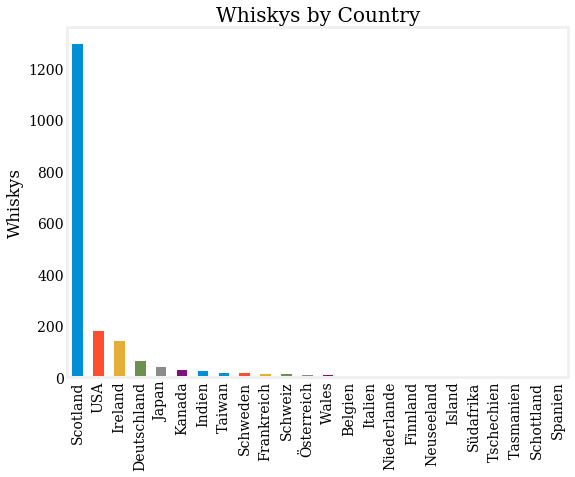

In [40]:
ax = df['country'].value_counts().plot('bar')
ax.set(ylabel='Whiskys', title='Whiskys by Country');

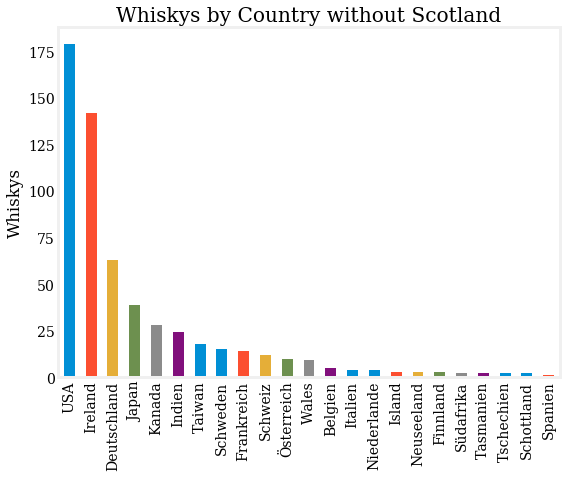

In [163]:
db=  df[ ~df['country'].str.contains("Scotland")] # .value_counts()
ax = db['country'].value_counts().plot('bar')#df['country'].str.contains("Scotland").value_counts().plot('bar')
ax.set(ylabel='Whiskys', title='Whiskys by Country without Scotland');

Let's check out the distribution of some straightforward metrics for each whisky.

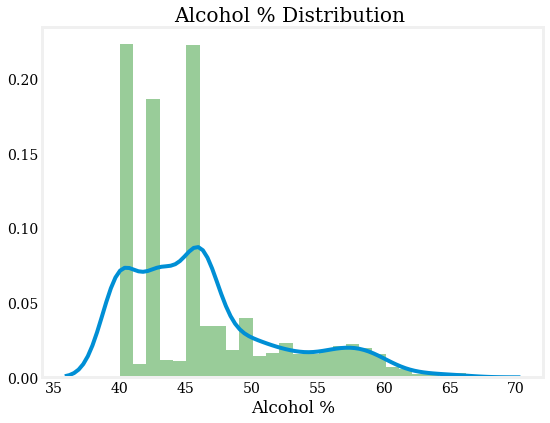

In [129]:
fig, ((ax1)

     ) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))



sns.distplot(df[df['country'].str.contains("Scotland")].alcohol.dropna(), ax=ax1, hist_kws={"color": "g"})
ax1.set(xlabel='Alcohol %', title='Alcohol % Distribution ');

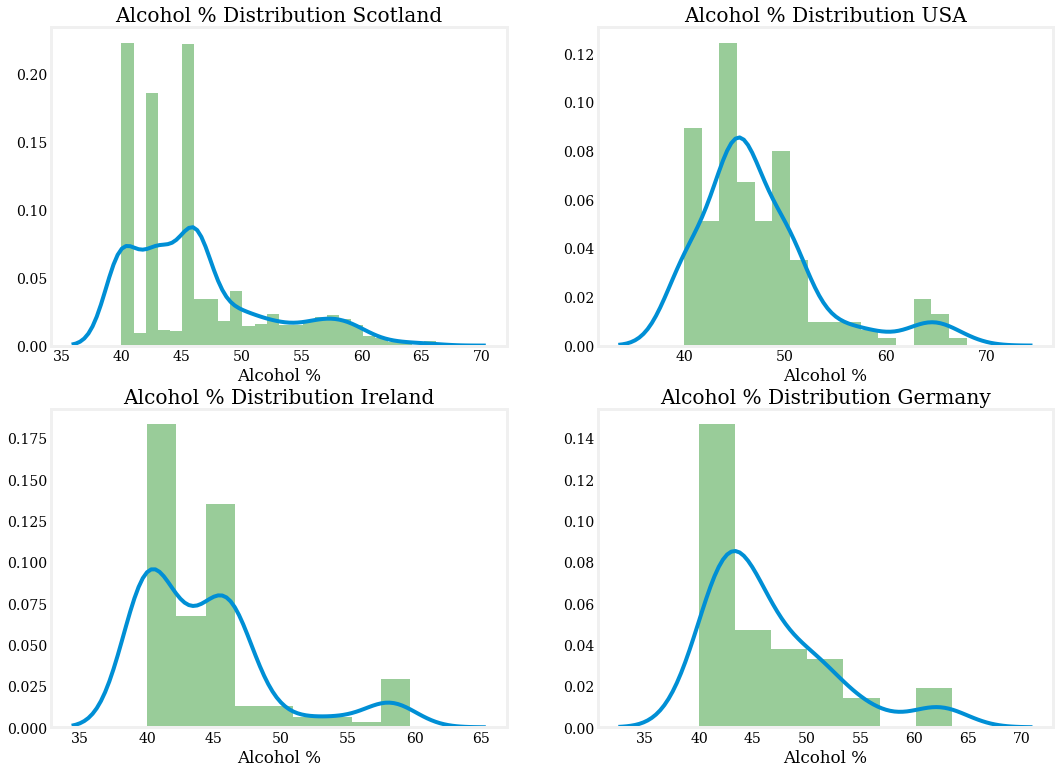

In [122]:
fig, ((ax1, ax2), 
      (ax3,ax4),

     ) = plt.subplots(ncols=2, nrows=2, figsize=(16,12))


sns.distplot(df[df['country'].str.contains("Scotland")].alcohol.dropna(), ax=ax1, hist_kws={"color": "g"})
ax1.set(xlabel='Alcohol %', title='Alcohol % Distribution Scotland');

sns.distplot(df[df['country'].str.contains("USA")].alcohol.dropna(), ax=ax2, hist_kws={"color": "g"})
ax2.set(xlabel='Alcohol %', title='Alcohol % Distribution USA');

sns.distplot(df[df['country'].str.contains("Ireland")].alcohol.dropna(), ax=ax3, hist_kws={"color": "g"})
ax3.set(xlabel='Alcohol %', title='Alcohol % Distribution Ireland');

sns.distplot(df[df['country'].str.contains("Deutschland")].alcohol.dropna(), ax=ax4, hist_kws={"color": "g"})
ax4.set(xlabel='Alcohol %', title='Alcohol % Distribution Germany');

#sns.distplot(df[df['country'].str.contains("Deutschland")].alcohol.dropna(), ax=ax5)
#ax5.set(xlabel='Alcohol %', title='Alcohol % Distribution ');



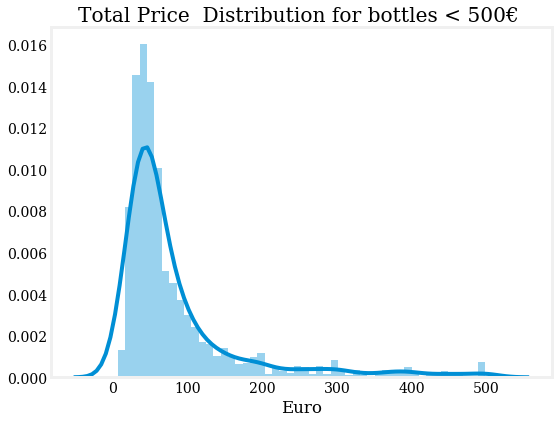

In [116]:
fig, ((ax1)

     ) = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.distplot(df[ df.price < 500].price.dropna(), ax=ax1)
ax1.set(xlabel='Euro', title='Total Price  Distribution for bottles < 500€ ');

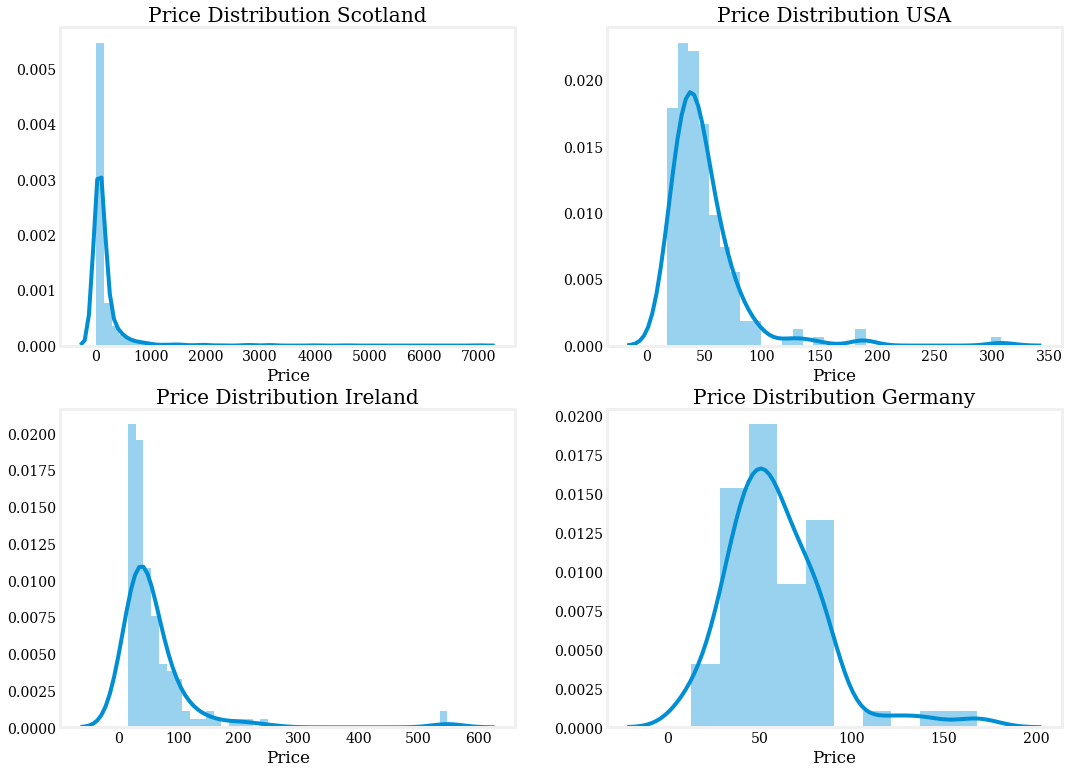

In [117]:
fig, ((ax1, ax2), 
      (ax3,ax4),

     ) = plt.subplots(ncols=2, nrows=2, figsize=(16,12))
#@todo df.price < 100 for all countries

sns.distplot(df[df['country'].str.contains("Scotland") ].price.dropna(), ax=ax1)
ax1.set(xlabel='Price', title='Price Distribution Scotland');

sns.distplot(df[df['country'].str.contains("USA")].price.dropna(), ax=ax2)
ax2.set(xlabel='Price', title='Price Distribution USA');

sns.distplot(df[df['country'].str.contains("Ireland")].price.dropna(), ax=ax3)
ax3.set(xlabel='Price', title='Price Distribution Ireland');

sns.distplot(df[df['country'].str.contains("Deutschland")].price.dropna(), ax=ax4)
ax4.set(xlabel='Price', title='Price Distribution Germany');


An immediate observation is the almost-normal distribution one sees for the `Average Rating` column with a high mean of 85+.
[Kroutoner on Reddit](https://www.reddit.com/r/datascience/comments/7e0mw5/analyzing_1000_greek_wines_with_python/dq1x4ls/) explains why this happens (and also corrects a previous mistake of mine):

*The typical wine rating scale is on 50-100, not 0-100. So what looked like was a distribution with only half support is actually a nearly fully supported distribution with slight left skew. Further, there's a huge difference culturally between wines with ratings below and above 90, with wines receiving a rating above 90 generally being considered significantly better and also selling significantly better. This cultural fact completely changes the reasonable interpretation of the data. Most wines are rated as ok and only a small portion being rated as really good.*


# @todo: what next? flavours?  average ratings by country